In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [2]:
def normalize(x):
    eta, u, v = x[:,0,:,:], x[:,1,:,:], x[:,2,:,:]
    u_max, u_min = u.max(), u.min()
    v_max, v_min = v.max(), v.min()
    eta_max, eta_min = eta.max(), eta.min()
    
    eta_norm = 2 * (eta - eta_min) / (eta_max - eta_min) - 1
    u_norm = 2 * (u - u_min) / (u_max - u_min) - 1
    v_norm = 2 * (v - v_min) / (v_max - v_min) - 1

    u_norm = u_norm.unsqueeze(1)
    v_norm = v_norm.unsqueeze(1)
    eta_norm = eta_norm.unsqueeze(1)

    x_norm = torch.cat((eta_norm, u_norm, v_norm), dim=1)

    return x_norm, [u_max, u_min, v_max, v_min, eta_max, eta_min]

def denormalize(x_norm, max_min_vals):
    eta_norm, u_norm, v_norm = x_norm[:,0,:,:], x_norm[:,1,:,:], x_norm[:,2,:,:]
    u_max, u_min, v_max, v_min, eta_max, eta_min  = max_min_vals

    u = ((u_norm + 1) / 2) * (u_max - u_min) + u_min
    v = ((v_norm + 1) / 2) * (v_max - v_min) + v_min
    eta = ((eta_norm + 1) / 2) * (eta_max - eta_min) + eta_min

    u = u.unsqueeze(1)
    v = v.unsqueeze(1)
    eta = eta.unsqueeze(1)
    x = torch.cat((eta, u, v), dim=1)
    
    return x
    
def plot_figs(idx, X1, X2):  
    # function used to plot actual vs predicted initial conditions for 1 datapoint
    x = np.linspace(0, 1, 64)
    y = np.linspace(0, 1, 64)
    X, Y = np.meshgrid(x, y)

    eta1 = X1[idx, 0, :, :].cpu()
    u1 = X1[idx, 1, :, :].cpu()
    v1 = X1[idx, 2, :, :].cpu()
    eta2 = X2[idx, 0, :, :].cpu()
    u2 = X2[idx, 1, :, :].cpu()
    v2 = X2[idx, 2, :, :].cpu()
    #err_eta = torch.abs(eta1 - eta2)
    #err_u = torch.abs(u1 - u2)
    #err_v = torch.abs(v1 - v2)

    fig, axes = plt.subplots(2, 3, figsize=(18, 8), subplot_kw={'projection': '3d'})

    titles = [
        "Actual η", "Actual u", "Actual v",
        "Linear Predicted η", "Linear Predicted u", "Linear Predicted v"
    ]
    Zs = [eta1, u1, v1, eta2, u2, v2]
    cmaps = ['viridis', 'viridis', 'plasma', 'viridis', 'viridis', 'plasma']

    for i, ax in enumerate(axes.flat):
        ax.plot_surface(X, Y, Zs[i], cmap=cmaps[i])
        if i==1 or i==2 or i==4 or i==5:
            ax.set_zlim(-1e-3, 1e-3)
        ax.set_title(titles[i], fontsize=18, pad=10)
        ax.tick_params(axis='both', labelsize=10)
        ax.set_xlabel('x', fontsize=12, labelpad=5)
        ax.set_ylabel('y', fontsize=12, labelpad=5)

    # Try to reduce whitespace (tight_layout often has limited effect on 3D)
    #plt.tight_layout(pad=2.0)
    plt.subplots_adjust(hspace=0.3, wspace=0.1)  # manual tuning

    plt.show()

### Implement Optimal Inverse Theory (linear) for SWE

In [3]:
# load datasets
data_set = torch.load('data/training_data_10000.pt').clone()
ic_set = torch.load('data/ic_training_data_10000.pt').clone()

# to follow the same flow as nonlinear case, normalize and add noise, then denormalize
dataset_normalized, min_max_vals = normalize(data_set)
dataset_normalized += 0.1 * torch.randn(dataset_normalized.shape)
dataset_denormalized = denormalize(dataset_normalized, min_max_vals)

In [4]:
# problem is to find X given Y, so ic_set=X and data_set = Y
# also, want to reshape each X and Y to [3x64x64, size]

size = 10000
params = 3*64*64
Y = dataset_denormalized.view(size, params).T
X = ic_set.view(size, params).T

Recall from Theorem 3, that

the optimal inverse map is , $A=(\Gamma_X F^\top (L_y^\dagger)^\top)_r L_y ^\dagger$

and $\Gamma_X F^\top = XY^\top $ 

Since $L_y$ here is full-rank, its pseudo-inverse is equivalent to its inverse, which is what we use in the following code.

In [6]:
reg = 1e-2 # regularization term to be added to the gamma_X and gamma_Y matrices to ensure SPD 
#               (necessary because we use Cholesky decomposition as the symmetric factorization)

gamma_Y = (1/(size-1)) * (Y @ Y.T + reg * torch.eye(Y.shape[0], device=Y.device))
L_y = torch.linalg.cholesky(gamma_Y)
print('L_y computed')

L_y_inv = torch.linalg.inv(L_y)
L_y_inv_transpose = L_y_inv.T
print('L_y inverse and inverse trasnpose computed')

term_1 = (1/(size-1)) * (X @ Y.T)    # Gamma_x F^transpose term 
print('Gamma_X F transpose term computed ')

# note that computing the SVD is a computationally intensive process, and takes approximately 5 minutes with the 
# data we are using

U, Sigma, Vt = torch.linalg.svd(term_1 @ L_y_inv_transpose)
print('SVD computed')


L_y computed
L_y inverse and inverse trasnpose computed
Gamma_X F transpose term computed 
SVD computed


In [7]:
r = 250 # rank r of linear mapping A
r_truncation = U[:,:r] @ torch.diag(Sigma[:r]) @ Vt[:r, :]
print('r truncation of term 1 computed')

8 done


In [8]:
# A = r_truncation @ L_y_inv
# reconstruct x from y and calculate error

X_hat = (r_truncation @ L_y_inv) @ Y

reconstructions = X_hat.T.view(size, 3, 64, 64)

total_err = torch.norm(reconstructions - ic_set) / torch.norm(ic_set)
eta_err = torch.norm(reconstructions[:,0,:,:] - ic_set[:,0,:,:] ) / torch.norm(ic_set[:,0,:,:])
u_err = torch.abs(reconstructions[:,1,:,:]  - ic_set[:,1,:,:] ).mean()
v_err = torch.abs(reconstructions[:,2,:,:]  - ic_set[:,2,:,:]).mean()

print(f'Total Error : {total_err}')
print(f'eta error : {eta_err} , u error : {u_err} , v error : {v_err}')

Total Error : 0.00667085126042366
eta error : 0.0066827330738306046 , u error : 6.289993325481191e-05 , v error : 6.288915028562769e-05


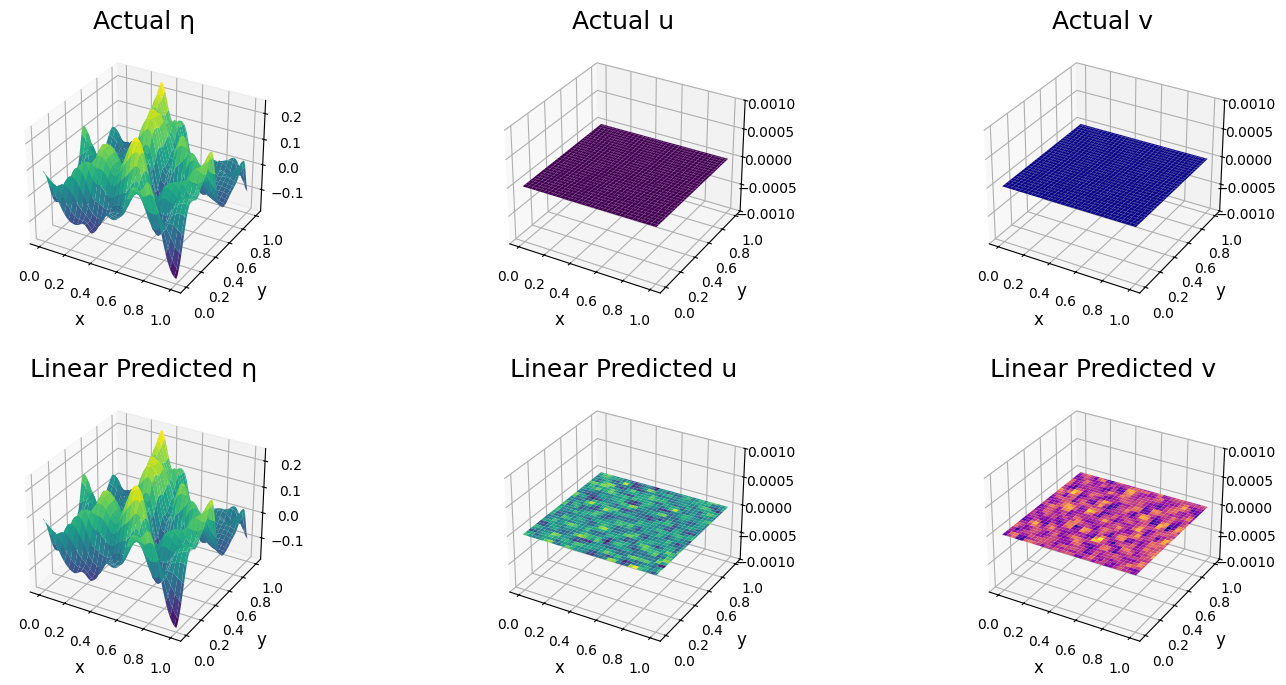

Total Error : 0.01900576613843441
eta error : 0.01900576613843441 , u error : 7.51036282053974e-07 , v error : 7.41706003282161e-07


In [11]:
# --- for one instance, plot original vs reconstructed values and also compute error ---
idx = 4000
original = ic_set
predicted = reconstructions

plot_figs(idx, original, predicted)

# --- errors in individual variables ---
total_err = torch.norm(reconstructions[idx,:,:,:] - ic_set[idx,:,:,:]) / torch.norm(ic_set[idx,:,:,:])
eta_err = torch.norm(reconstructions[idx,0,:,:] - ic_set[idx,0,:,:] ) / torch.norm(ic_set[idx,0,:,:])
u_err = torch.abs(reconstructions[idx,1,:,:]  - ic_set[idx,1,:,:] ).mean()
v_err = torch.abs(reconstructions[idx,2,:,:]  - ic_set[idx,2,:,:]).mean()

print(f'Total Error : {total_err}')
print(f'eta error : {eta_err} , u error : {u_err} , v error : {v_err}')

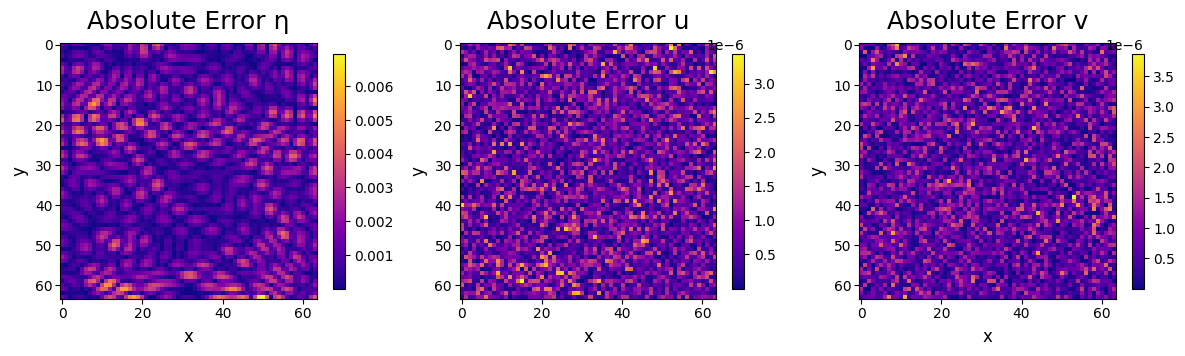

In [19]:
# --- plot error charts in all 3 variables ---

eta1 = ic_set[idx, 0, :, :].cpu()
u1 = ic_set[idx, 1, :, :].cpu()
v1 = ic_set[idx, 2, :, :].cpu()
eta2 = reconstructions[idx, 0, :, :].cpu()
u2 = reconstructions[idx, 1, :, :].cpu()
v2 = reconstructions[idx, 2, :, :].cpu()
err_eta = torch.abs(eta1 - eta2) 
err_u = torch.abs(u1 - u2) 
err_v = torch.abs(v1 - v2)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

titles = [ "Absolute Error η", "Absolute Error u", "Absolute Error v" ]
Zs = [err_eta, err_u, err_v]

for i, ax in enumerate(axes.flat):
    cb = ax.imshow(Zs[i], cmap='plasma')
    plt.colorbar(cb, shrink=0.5)
    ax.set_title(titles[i], fontsize=18, pad=10)
    ax.tick_params(axis='both', labelsize=10, pad=2)
    ax.set_xlabel('x', fontsize=12, labelpad=5)
    ax.set_ylabel('y', fontsize=12, labelpad=5)
fig.set_tight_layout(True)

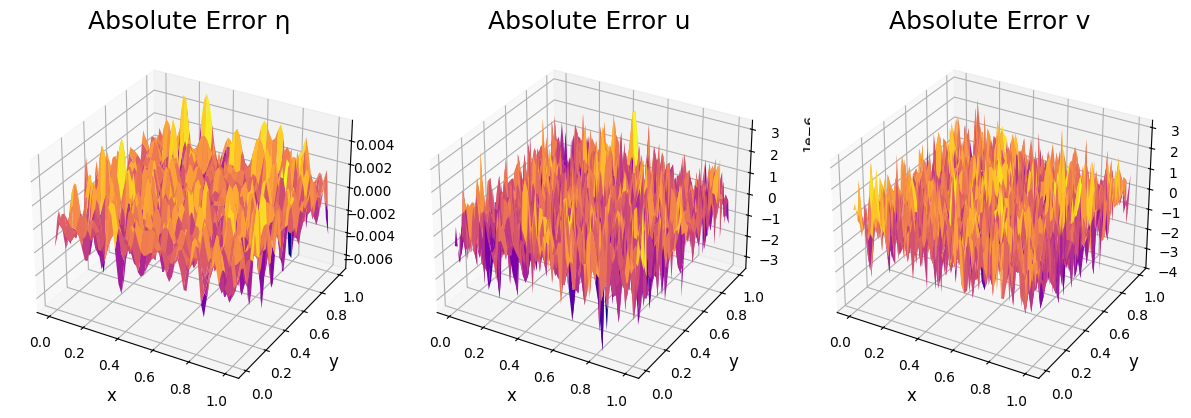

In [22]:
err_eta = (eta1 - eta2) 
err_u = (u1 - u2) 
err_v = (v1 - v2)

fig, axes = plt.subplots(1, 3, figsize=(12, 10), subplot_kw={'projection': '3d'})

titles = [ "Absolute Error η", "Absolute Error u", "Absolute Error v" ]
Zs = [err_eta, err_u, err_v]
x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)
X, Y = np.meshgrid(x, y)

for i, ax in enumerate(axes.flat):
    ax.plot_surface(X,Y, Zs[i], cmap='plasma')
    ax.set_title(titles[i], fontsize=18, pad=10)
    ax.tick_params(axis='both', labelsize=10, pad=2)
    ax.set_xlabel('x', fontsize=12, labelpad=5)
    ax.set_ylabel('y', fontsize=12, labelpad=5)
fig.set_tight_layout(True)

In [28]:
r_list = np.arange(100,2000,100)
err_list = np.zeros((r_list.shape[0], 4))
i=0
for r in r_list:
    r_truncation = U[:,:r] @ torch.diag(Sigma[:r]) @ Vt[:r, :]
    X_hat = (r_truncation @ L_y_inv) @ Y
    reconstructions = X_hat.T.view(size, 3, 64, 64)
    total_err = torch.norm(reconstructions - ic_set) / torch.norm(ic_set)
    eta_err = torch.norm(reconstructions[:,0,:,:] - ic_set[:,0,:,:] ) / torch.norm(ic_set[:,0,:,:])
    u_err = torch.abs(reconstructions[:,1,:,:]  - ic_set[:,1,:,:] ).mean()
    v_err = torch.abs(reconstructions[:,2,:,:]  - ic_set[:,2,:,:]).mean()
    err_list[i,:] = total_err, eta_err, u_err, v_err
    i += 1

    

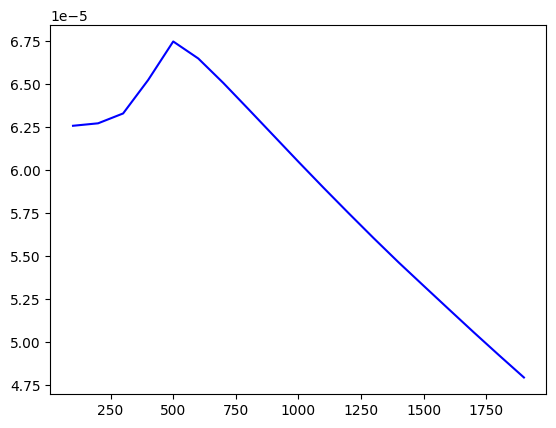

In [35]:
fig, ax = plt.subplots(1,1)

ax.plot(r_list, err_list[:,3], 'b-')